In [1]:
%run mqtt_thingy.ipynb

In [2]:
%cd ./util_interfaces/
%run advance_dashboard.ipynb

/home/dlar58/Documents/transformable-robot-hardware/Hardware_Control_ESP32/util_interfaces
info
        
        Always be aware that this version of dashboard is instanced when defination.
        Which means that there cannot be two dashboard in the same ipynb kernel.
        
        


Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

In [3]:
    # R1=Responder(("10.144.113.5",1885),"ho1_ret")
    # R1.to="ho1"

In [4]:
    LF=Responder(("10.144.113.5",1885),"ho3_ret")
    LF.to="ho3"

/tmp/ipykernel_324681/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Connected successfully!


In [5]:
    RF=Responder(("10.144.113.5",1885),"ho2_ret")
    RF.to="ho2"

/tmp/ipykernel_324681/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


In [6]:
def rett(task):
    k=ipywidgets.Textarea(layout=ipywidgets.Layout(width='500px', height='100px'))
    task.start()
    return (k,)

@TaskHandlerButtonAdvanced.add_to_state_button(s, rett)
async def control_loop(task, sleep_interval=0.05, keep_len=10):
    global actions
    obs = task.widgets[0]
    
    @loop(sleep_interval)
    def go():
        obs.value="\n".join([str(i) for i in LF.ret_list][::-1])
    
    # await asyncio.gather(R.loop_recv(),go())
    await asyncio.gather(go())
t=control_loop("control_loop")

Connected successfully!


In [7]:
await asyncio.sleep(0.1)

In [8]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import time


In [9]:
s.display()

Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

Box(children=(StateButton(description='control_loop', layout=Layout(height='30px'), style=ButtonStyle(button_c…

In [10]:
## In the current bipedal configuration
## Motor 1, 3 ,5 will have opposite joint angles
## Motor 2, 4 will have identical joint angles

In [11]:
#%% Define constants and parameters

n = 5 # for one single leg

# Frequency
omega_val = 2 * np.pi
omegaLF = np.ones(n) * omega_val
omegaRF = np.ones(n) * omega_val


# Convergence rate
mu_const = 1
mu = np.ones(n) * mu_const
# muLF = np.ones(n) * mu_const
# muRF = np.ones(n) * mu_const


# Amplitude
a_val = 10
a_paramLF = np.ones(n) * a_val
a_paramRF = np.ones(n) * a_val



# Tune the code after these:


# R_ampLF = np.array([30, 60, 45, 0 ,0.])
# R_ampRF = np.array([ -0, 60, -45, 0, -0.0])



# # For both simulation and hardware:  hop straight (to be tuned)
# R_ampLF = np.array([30, 60, 30, 0 ,0.])
# R_ampRF = np.array([-30, 60, -30, 0, -0.0])

# For both simulation and hardware:  go straight
R_ampLF = np.array([0, 60, 20, 0 ,0.])
R_ampRF = np.array([0, 60, -20, 0, -0.0])


# # For both simulation and hardware:  left turn
# R_ampLF = np.array([0, 60, 20, 0 ,0.])
# R_ampRF = np.array([ 0, 60, -20, 0, -0.0])*0.1


# # Mechanical offsets
# los = np.array([3, 3, 3, 3, 3])
# ros = np.array([-12, -12, -12, -12, -12])


# Joint offsets: For integration

# OffsetsLF = np.array([95, 0, 5, -70, -90])
# OffsetsRF = np.array([-100, 0, -5, -70, 85])


# # hop straight: hand tuning offsets(to be tuned)
# OffsetsLF = np.array([100, 0, -10, -75, -90])
# OffsetsRF = np.array([-100, 0, 5, -85, 90])




# Walking straight: hand tuning offsets(hardware)
OffsetsLF = np.array([90, 0, 0, -75, -90])
OffsetsRF = np.array([-105, 0, -5, -85, 90])

# # Walking straight: on hardware(hardware)
# OffsetsLF = np.array([90, 0, 0, -90, -90])*0.9
# OffsetsRF = np.array([-90, 0, -0, -90, 90])*1.1


# # Use these for simulation: fully symmetric
# OffsetsLF = np.array([90, 0, 0, -90, -90])
# OffsetsRF = np.array([-90, 0, -0, -90, 90])



# Desired phase differences

# high-level phase: LF, RF
# To change the initial condition of integration, as a high level CPG parameter
phi_tilde_high = [0, 0]   # for two legs synchronized
# phi_tilde_high = [0, np.pi]   # phase delays of between two legs: half of the period


# phi_tilde = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi,    0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi]  # forward： hop
phi_tilde_lf = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi]
phi_tilde_rf = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi]

theta_tilde_lf=[phi_tilde_lf[i+1]-phi_tilde_lf[i] for i in range(4)]
theta_tilde_rf=[phi_tilde_rf[i+1]-phi_tilde_rf[i] for i in range(4)]


# phi_tilde = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi,    np.pi, 2*np.pi, 2*np.pi, 1*np.pi, 1*np.pi]  # forward： walk

phi_tilde_lf = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi]
phi_tilde_rf = [0, 1*np.pi, 1*np.pi, 0*np.pi, 0*np.pi]
# phi_tilde_rf = [x + phi_tilde_high[1] for x in phi_tilde_rf]

theta_tilde_lf=[phi_tilde_lf[i+1]-phi_tilde_lf[i] for i in range(4)]
theta_tilde_rf=[phi_tilde_rf[i+1]-phi_tilde_rf[i] for i in range(4)]



# phi_tilde = [0, 0, np.pi/2, 0, 0, 0, 0, 0, 0, 0]  # turning

# theta_tilde=[phi_tilde[i+1]-phi_tilde[i] for i in range(9)]

#%% ODE setup
phi0_lf = np.zeros(n)   # initial phases
r0_lf   = np.zeros(n)   # initial amplitudes
dr0_lf  = np.zeros(n)   # initial amplitude derivatives

x0_lf = np.concatenate((phi0_lf, r0_lf, dr0_lf))


phi0_rf = np.zeros(n) + phi_tilde_high[1]   # initial phases
r0_rf   = np.zeros(n)   # initial amplitudes
dr0_rf  = np.zeros(n)   # initial amplitude derivatives

x0_rf = np.concatenate((phi0_rf, r0_rf, dr0_rf))


# integration time step (change this if you want to change the speed)
dt  = 0.05


In [12]:
#%% Matrices A and B
A = np.zeros((n, n))
A[0, 0] = -mu[0]
if n >= 2:
    A[0, 1] = mu[1]
for i in range(1, n - 1):
    A[i, i - 1] = mu[i]
    A[i, i]     = -2 * mu[i]
    A[i, i + 1] = mu[i]
A[n - 1, n - 2] = mu[n - 1]
A[n - 1, n - 1] = -mu[n - 1]

B = np.zeros((n, n - 1))
B[0, 0] = 1
for i in range(1, n - 1):
    B[i, i - 1] = -1
    B[i, i]     = 1
B[n - 1, n - 2] = -1



t_span = (0, 20)  # simulate for 20 seconds
t_eval = np.linspace(t_span[0], t_span[1], int(t_span[1]/dt)) # time points: based on dt and t_span

#%% ODE function definition
def cpgODE(t, x, omega, A, B, theta_tilde, a_param, R_amp, n):
    """
    Compute the derivatives for the CPG system.
    x is [phi, r, dr] with each block of length n.
    Returns: [dphi; dr; ddr]
    """
    phi = x[0:n]
    r   = x[n:2*n]
    dr  = x[2*n:3*n]

    # Phase derivatives
    dphi = omega + A.dot(phi) + B.dot(theta_tilde)

    # Second derivatives for amplitude
    ddr = a_param * ((a_param / 4) * (R_amp - r) - dr)

    # Note: The derivative of r is dr (not r)
    return np.concatenate((dphi, dr, ddr))

#%% Solve the ODE
sol_lf = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaLF, A, B, theta_tilde_lf, a_paramLF, R_ampLF, n),
    t_span,
    x0_lf,
    t_eval=t_eval
)

sol_rf = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaRF, A, B, theta_tilde_rf, a_paramRF, R_ampRF, n),
    t_span,
    x0_rf,
    t_eval=t_eval
)


t_lf = sol_lf.t
x_lf = sol_lf.y.T  # shape (time_points, 3*n)

t_rf = sol_rf.t
x_rf = sol_rf.y.T  # shape (time_points, 3*n)



#%% Extract the results
phi_lf = x_lf[:, :n]          # phases
r_lf   = x_lf[:, n:2*n]       # amplitudes
dr_lf  = x_lf[:, 2*n:3*n]     # amplitude derivatives


#%% Extract the results
phi_rf = x_rf[:, :n]          # phases
r_rf   = x_rf[:, n:2*n]       # amplitudes
dr_rf  = x_rf[:, 2*n:3*n]     # amplitude derivatives


# Compute the rhythmic output signals: x_i = r_i * sin(phi_i)
desired_angle_lf = r_lf * np.sin(phi_lf) + np.ones(phi_lf.shape)*OffsetsLF
desired_angle_rf = r_rf * np.sin(phi_rf) + np.ones(phi_rf.shape)*OffsetsRF

normalize_min = -135
normalize_max = 135

In [13]:
# phi_rf[200,0] - phi_rf[200,1]

In [14]:
# Normalize the output from -1 to 1
desired_angle_lf_normalized = (desired_angle_lf - normalize_min) / (normalize_max - normalize_min) * 2 - 1
desired_angle_rf_normalized = (desired_angle_rf - normalize_min) / (normalize_max - normalize_min) * 2 - 1

# Change the decimal length
desired_angle_lf_normalized = np.round(desired_angle_lf_normalized,4)
desired_angle_rf_normalized = np.round(desired_angle_rf_normalized,4)

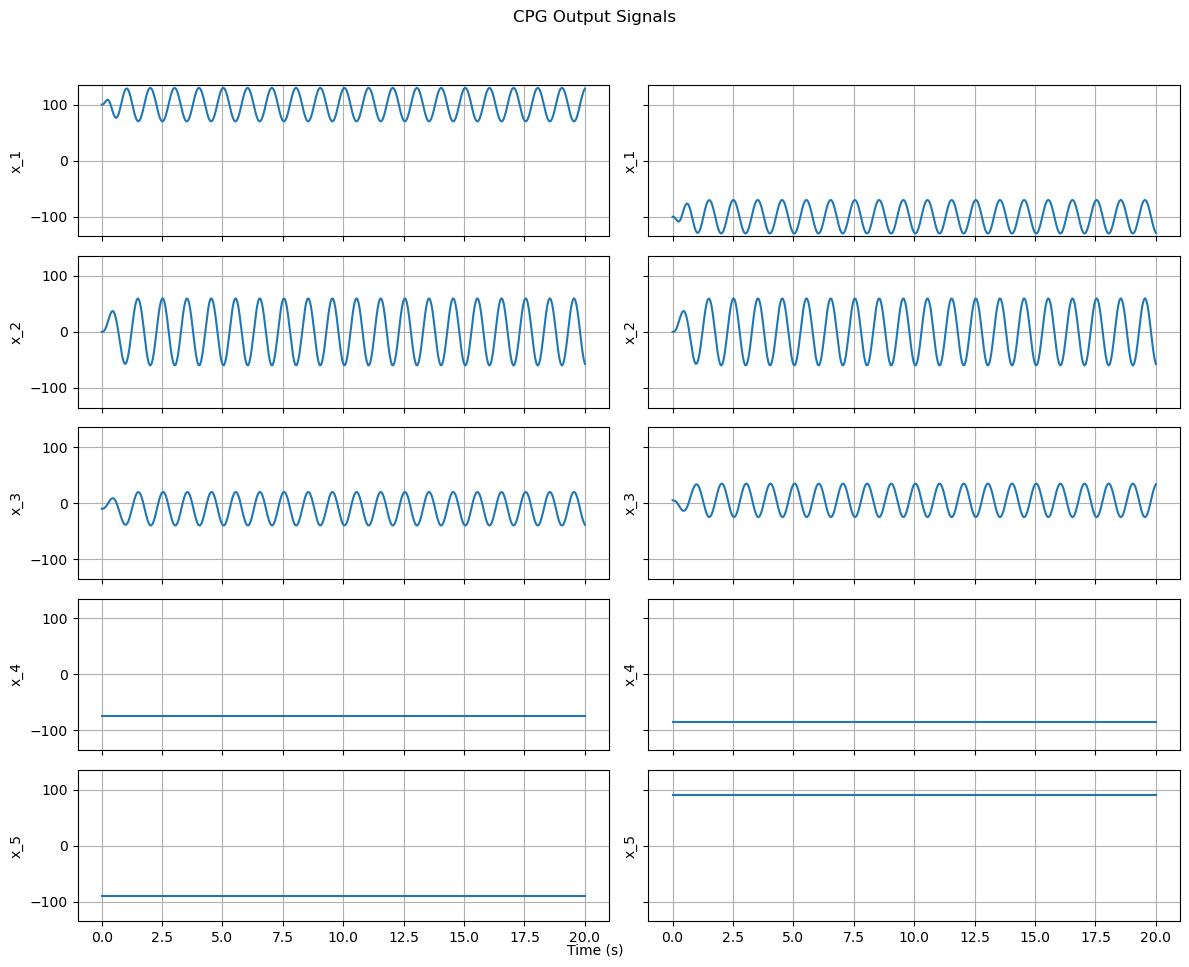

In [15]:
# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot(t_lf, desired_angle_lf[:, i], linewidth=1.5)
    axs[i, 0].set_ylabel(f'x_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot(t_rf, desired_angle_rf[:, i], linewidth=1.5)
    axs[i, 1].set_ylabel(f'x_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [16]:
# dir_map = np.array([-1, 1, -1, 1, -1])

# desired_angle_lf[40,:] - desired_angle_rf[40,:]*dir_map

In [17]:
# pps = int(2*np.pi/(phi_rf[11,1]-phi_rf[10,1]))

In [18]:
# pps

In [19]:
# # Create a figure with n rows and 2 columns
# fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# # Loop over each oscillator to plot its corresponding row
# for i in range(n):
#     # Left column: plots for the first dataset
#     axs[i, 0].plot(t_lf[2*pps:3*pps:1], desired_angle_lf[2*pps:3*pps, i], linewidth=1.5)
#     axs[i, 0].set_ylabel(f'x_{i+1}')
#     axs[i, 0].grid(True)
#     axs[i, 0].set_ylim(-135, 135)
    
#     # Right column: plots for the second dataset
#     axs[i, 1].plot(t_rf[2*pps:3*pps:1], desired_angle_rf[2*pps:3*pps, i], linewidth=1.5)
#     axs[i, 1].set_ylabel(f'x_{i+1}')
#     axs[i, 1].grid(True)
#     axs[i, 1].set_ylim(-135, 135)

# # Add a common x-label and a title for the entire figure
# fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
# fig.suptitle('CPG Output Signals', y=0.98)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


In [20]:
# pps = int(2*np.pi/(phi_rf[11,1]-phi_rf[10,1]))

# llf_pre = desired_angle_lf_normalized[2*pps,:]
# lrf_pre = desired_angle_rf_normalized[2*pps,:]

# # llf_pre[0] = llf_pre[0] + 10/135

# LF.send_exe(f"esp.pca_moves({llf_pre.tolist()})")
# RF.send_exe(f"esp.pca_moves({lrf_pre.tolist()})")

# await asyncio.sleep(1)

# # break

In [21]:
# pps = int(2*np.pi/(phi_rf[11,1]-phi_rf[10,1]))

# llf = desired_angle_lf_normalized[2*pps:3*pps:1,:].tolist()
# lrf = desired_angle_rf_normalized[2*pps:3*pps:1,:].tolist()

# LF.send_exe(f"esp.ta=loop.create_task(from_li({llf},0.05,5))")
# RF.send_exe(f"esp.ta=loop.create_task(from_li({lrf},0.05,5))")


In [22]:
InitL = np.array([0, 0, 0, 0, 0])*(1/135)
InitR = np.array([0, 0, 0, 0, 0])*(1/135)
LF.send_exe(f"esp.pca_moves({InitL.tolist()})")
RF.send_exe(f"esp.pca_moves({InitR.tolist()})")

In [23]:
await asyncio.sleep(1)

In [24]:
LF.send_exe(f"esp.flag=False")
RF.send_exe(f"esp.flag=False")

In [25]:
await asyncio.sleep(1)

In [26]:

# JRF = np.array([-90, 0, -0, -75, 90])*(1/135)
# RF.send_exe(f"esp.pca_moves({JRF.tolist()})")

In [27]:
# pps = int(2 * np.pi / (phi_rf[11, 1] - phi_rf[10, 1]))

# noi = 5  # Define the number of iterations
# osp = 2
# pps_multiplier = 1

# for i in range(noi):

#     llf = desired_angle_lf_normalized[(i*pps_multiplier+osp) * pps : ((i+1)*pps_multiplier+osp) * pps, :].tolist()
#     lrf = desired_angle_rf_normalized[(i*pps_multiplier+osp) * pps : ((i+1)*pps_multiplier+osp) * pps, :].tolist()

#     LF.send_exe(f"esp.ta=loop.create_task(from_li({llf},0.05,1))")
#     RF.send_exe(f"esp.ta=loop.create_task(from_li({lrf},0.05,1))")


In [28]:
pps = int(2*np.pi/(phi_rf[11,1]-phi_rf[10,1]))

llf = desired_angle_lf_normalized[2*pps:3*pps:1,:].tolist()
lrf = desired_angle_rf_normalized[2*pps:3*pps:1,:].tolist()

LF.send_exe(f"esp.ta=loop.create_task(from_li({llf},0.05,10))")
RF.send_exe(f"esp.ta=loop.create_task(from_li({lrf},0.05,10))")


In [29]:
# pps = 150

# noi = 1 # Define the number of iterations

# pps_multiplier = 1

# for i in range(noi):

#     llf = desired_angle_lf_normalized[i*pps_multiplier * pps : (i+1)*pps_multiplier * pps, :].tolist()
#     lrf = desired_angle_rf_normalized[i*pps_multiplier * pps : (i+1)*pps_multiplier * pps, :].tolist()

#     LF.send_exe(f"esp.ta=loop.create_task(from_li({llf},0.05,5))")
#     RF.send_exe(f"esp.ta=loop.create_task(from_li({lrf},0.05,5))")


In [30]:
InitL = np.array([0, 0, 0, 0, 0])*(1/135)
InitR = np.array([0, 0, 0, 0, 0])*(1/135)
LF.send_exe(f"esp.pca_moves({InitL.tolist()})")
RF.send_exe(f"esp.pca_moves({InitR.tolist()})")

In [31]:
# li = [-0.278, 0.6667, 0.8552, -0.7037, -0.6667]

# LF.send_exe(f"esp.pca_moves({li})")


In [32]:
# li = [0.5353, 0.6667, -0.533, -0.6296, 0.6667]
# RF.send_exe(f"esp.pca_moves({li})")

In [33]:
# InitL = np.array([3, 3, 3, 3, 3])*(1/135)
# # InitR = np.array([-12, -12, -12, -12, -12])*(1/135)
# LF.send_exe(f"esp.pca_moves({InitL.tolist()})")
# RF.send_exe(f"esp.pca_moves({InitR.tolist()})")

In [34]:
# InitL = np.array([90, 90, 0, -90, -90])*(1/135)
# InitR = np.array([-90, 90, 0, -90, 90])*(1/135)
# LF.send_exe(f"esp.pca_moves({InitL.tolist()})")
# RF.send_exe(f"esp.pca_moves({InitR.tolist()})")

In [35]:
desL = np.array([0, 0, 0, 0, 0])*(1/135)
desR = np.array([0, 0, 0, 0, 0])*(1/135)
LF.send_exe(f"esp.pca_moves({desL.tolist()})")
RF.send_exe(f"esp.pca_moves({desR.tolist()})")

In [36]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
LF.send_exe(f"esp.ta.cancel()")
RF.send_exe(f"esp.ta.cancel()")